Construction of Neural Network with numpy: 

INTRODUCTION
A artifical neural network(ANN) consists of layers containing nodes. Each node has inputs, weights and a bias. The output of a node is the sum of every input * its weight plus the bias value. In this assignment, I utilized a constructed neural network which outputs a binary classification for DNA sequences as sites for transcription binding. 
This multilayer-feed forward network utilizes backpropagation, a supervised learning method, used for classification and regression problems. Below are the following steps to the design of the ANN:
1. Intialized network
2. Foward Propagation
3. Back Porpagate
4. Train Network
5. Predict 

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from Parse_seq import *



np.set_printoptions(formatter={"float": "{: 0.3f}".format}, linewidth=np.inf)
np.random.seed(1)

def sigmoid(z, derivative=False):
    if derivative:
        z = sigmoid(z)
        return z * (1 - z)
    z = np.clip(z, -500, 500)  # avoid overflow
    return 1 / (1 + np.exp(-z))

class NN:
    def __init__(self, shape, activation=None):
        self.num_layers = len(shape) - 1  # the input layer does not count as a layer
        self.weight = []
        self.bias = []

        if activation is None:  # activation tuple is optional
            self.activation = [sigmoid for _ in range(self.num_layers)]
        else:
            if len(shape) != len(activation):
                raise ValueError("nr of layers ({}) must match activations ({})".format(len(shape), len(activation)))
            self.activation = activation[1:]  # skip the activation function for the input layer

        self.a = []  # layers output after activation, input to the next layer
        self.z = []  # layers results before activation
        self.dw = []  # empty array used for weight update during training
        self.db = []  # empty array used for bias update during training

        for (layer1, layer2) in zip(shape[:-1], shape[1:]):
            self.weight.append(np.random.normal(size=(layer2, layer1)))
            self.bias.append(np.random.normal(size=(layer2, 1)))
            self.dw.append(np.zeros((layer2, layer1)))
            self.db.append(np.zeros((layer2, 1)))

    def forward(self, x):
        self.a = [x.T]  # a[0] is the input for layer 1 (layer 0 is the input layer)
        self.z = [None]

        for (weight, bias, activation) in zip(self.weight, self.bias, self.activation):
            self.z.append(weight.dot(self.a[-1]) + bias)
            self.a.append(activation(self.z[-1]))

        return self.a[-1].T

    def back_propagation(self, x, y, learning_rate=0.1, momentum=0.5):
        m = x.shape[0]
        delta_w = []
        delta_b = []

        y_hat = self.forward(x)
        #error = np.sum((y_hat - y) ** 2)
        error = np.sqrt(np.sum((y_hat - y) ** 2))

        for index in reversed(range(1, self.num_layers + 1)):
            if index == self.num_layers:
                da = self.a[index] - y.T
            else:
                da = self.weight[index].T.dot(dz)
            dz = da * self.activation[index - 1](self.z[index], derivative=True)
            dw = dz.dot(self.a[index - 1].T) / m
            db = np.sum(dz, axis=1, keepdims=True) / m

            delta_w.append(dw)
            delta_b.append(db)

        for (index, dw, db) in zip(reversed(range(self.num_layers)), delta_w, delta_b):
            self.dw[index] = learning_rate * dw + momentum * self.dw[index]
            self.weight[index] -= self.dw[index]
            self.db[index] = learning_rate * db + momentum * self.db[index]
            self.bias[index] -= self.db[index]

        return error
    
    def k_folds(self, sequences,expected, lr, n_hidden,k=5):
        """
        Perform cross validation using the k folds approach where data
        is split into training and testing sets k times using 100-k/k split
        """
        accuracy, auc, tpr, fpr = [], [], [], []
        # Split data
        skf = StratifiedKFold(n_splits=k)
        for train_ind, test_ind in skf.split(sequences, expected):
            train_seq, test_seq = sequences[train_ind], sequences[test_ind]
            train_exp, test_exp = expected[train_ind], expected[test_ind]
            # train and test model
            predictions = train_and_test(train_seq, train_exp, test_seq, n_hidden, lr)
            # Caclulate true positive and false positive rate
            fpr_roc, tpr_roc, thresholds = metrics.roc_curve(test_exp, predictions, pos_label=1)
            auc.append(metrics.auc(fpr_roc, tpr_roc))
            ACC, TPR, FPR = calc_static_sum_stats(test_exp, predictions)
            # Add summary stats across splits
            accuracy.append(ACC)
            tpr.append(TPR) 
            fpr.append(FPR)

        return np.average(accuracy), np.average(auc), tpr, fpr 

    def cross_validate(self, pos_seqs, neg_seqs, outfile, iters=10000):
        """
        Perform cross validation for a range of learning rates and hidden layers.
        Use kfold cross validation and output average accuracy
        """
        train_seq, train_exp, test_seq, test_exp = preprocess(pos_seqs, neg_seqs, split=1)
        with open(outfile, "w") as results:
            results.write("hidden_layers\tlearn_rate\tavg_accuracy\tavg_AUC\tTPR\tFPR\n")
            for num_hidden in range(1,30, 4):
                print(num_hidden)
                for learn_rate in np.arange(0.01, 0.5, 0.05):
                    print(learn_rate)
                    avg_accuracy, avg_auc, tprs, fprs = self.k_folds(train_seq, train_exp, learn_rate, num_hidden)
                    results.write("\t".join([str(num_hidden), str(learn_rate), str(avg_accuracy),
                    str(avg_auc), " ".join(tprs), " ".join(fprs)]))
                    results.write("\n")

    def plot_roc(predictions, exp_test, outfile):
        """
        plot ROC curve for predictions and expected values to asses model performance
        """
        fpr, tpr, thresholds = metrics.roc_curve(exp_test, predictions, pos_label=1)
        AUC = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Training Data (80/20) Split with AUC: " + str(AUC))
        plt.savefig(outfile, format="pdf")
        plt.close()
        return

    def train(self, x, y, iterations=10000, learning_rate=0.2, momentum=0.5, verbose=True):
        min_error = 1e-5
        loss = []

        for i in range(iterations + 1):
            error = self.back_propagation(x, y, learning_rate=learning_rate, momentum=momentum)
            loss.append(error)
            if verbose:
                if i % 2500 == 0:
                    print("iteration {:5d} error: {:0.6f}".format(i, error))
                if error <= min_error:
                    print("minimum error {} reached at iteration {}".format(min_error, i))
                    break

        return loss

Autoencoder:
    Below I contructed a 8X8 identity matrix with an autoencoder with 3 hidden neurons. The multilayer-feed forward network constructed with a 8X8 autoencoder with 3 hidden neurons, and a sigmoid activation fuction.The input and output layers have 8 neurons that include a bias term connected to adajent layer. 


Methodology: Network Architecture
    The function named NN() that creates a new neural network ready for training. It accepts three parameters, the number of inputs, the number of neurons to have in the hidden layer and the number of outputs.
For the hidden layer, create n_hidden neurons and each neuron in the hidden layer has n_inputs + 1 weights, one for each input column in a dataset and an additional one for the bias.You can also see that the output layer that connects to the hidden layer has n_outputs neurons, each with n_hidden + 1 weights. This means that each neuron in the output layer connects to (has a weight for) each neuron in the hidden layer.We can calculate an output from a neural network by propagating an input signal through each layer until the output layer outputs its values.

This is called forward-propagation. It is the technique needed to generate predictions during training that will need to be corrected, and it is the method we will need after the network is trained to make predictions on new data. The first step is to calculate the activation of one neuron given an input.The input could be a row from our training dataset, as in the case of the hidden layer. It may also be the outputs from each neuron in the hidden layer, in the case of the output layer. Neuron activation is calculated as the weighted sum of the inputs. Next to transfer the activation to see what the neuron output is this method uses sigmoid activation. Next we foward propagate the input. The function forward() implements the forward propagation for a row of data from our dataset with our neural network. The neuron’s output value is stored in the neuron with the name ‘z‘, 'a'. 
The function returns the outputs from the last layer also called the output layer.
The backpropagation algorithm is named for the way in which weights are trained. Error is calculated between the expected outputs and the outputs forward propagated from the network. These errors are then propagated backward through the network from the output layer to the hidden layer, assigning blame for error and updating weights. To calculate transfer derivative with the given output value from a neuron, the slope is caluculated using the sigmoid transfer function. In error backprogation the first step is to calculate the error for each output neuron, this will give the error signal (input) to propagate backwards through the network. The error signal calculated for each neuron  and is stored. For training the model the function train() is used. The errors calulated for each neuron is used to update the weights. Weight, learning_rate and number of iterations can be modified to update the wieghts. Gradient descent was used to update the model. This involves first looping for a fixed number of epochs and within each epoch updating the network for each row in the training dataset. Because updates are made for each training pattern. If errors were accumulated across an epoch before updating the weights, this is called batch learning or batch gradient descent. The function that implements the training of an already initialized neural network with a given training dataset, learning rate, fixed number of epochs and an expected number of output values.
The expected number of output values is used to transform class values in the training data into a one hot encoding. That is a binary vector with one column for each class value to match the output of the network. This is required to calculate the error for the output layer. The sum squared error between the expected output and the network output is accumulated each epoch and printed. This is helpful to create a trace of how much the network is learning and improving each epoch.

iteration     0 error: 4.446712
iteration  2500 error: 1.704280
iteration  5000 error: 1.159054
iteration  7500 error: 1.007614
iteration 10000 error: 0.805692
iteration 12500 error: 0.605414
iteration 15000 error: 0.502251
iteration 17500 error: 0.437484
iteration 20000 error: 0.391945
iteration 22500 error: 0.357703
iteration 25000 error: 0.330779
iteration 27500 error: 0.308916
iteration 30000 error: 0.290724
iteration 32500 error: 0.275292
iteration 35000 error: 0.261996
iteration 37500 error: 0.250391
iteration 40000 error: 0.240152
iteration 42500 error: 0.231035
iteration 45000 error: 0.222851
iteration 47500 error: 0.215453
iteration 50000 error: 0.208725
predict: [[ 0.961  0.000  0.000  0.013  0.023  0.000  0.026  0.022]
 [ 0.000  0.947  0.014  0.000  0.004  0.027  0.000  0.042]
 [ 0.000  0.023  0.955  0.000  0.035  0.028  0.009  0.000]
 [ 0.013  0.002  0.000  0.955  0.000  0.030  0.001  0.036]
 [ 0.015  0.003  0.028  0.000  0.961  0.000  0.000  0.025]
 [ 0.000  0.041  0.017  

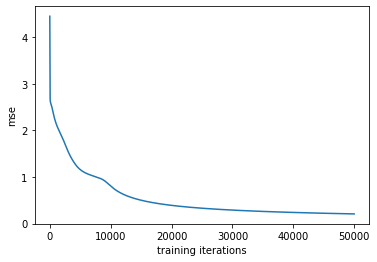

In [2]:
#Autoencoder 
X = np.identity(8)
Y = np.identity(8)

network = NN((8, 3, 8), (None, sigmoid, sigmoid))

error = network.train(X, Y, 50000, learning_rate=0.2)

plt.plot(error)
plt.xlabel("training iterations")
plt.ylabel("mse")

Y_hat = network.forward(X)

print("predict:", Y_hat.T)
print("desired:", Y.T)
print("loss   :", (Y - Y_hat).T)

plt.show()

#Autoencoder Results

The neural network designed a 8 dimension input 3 dimension hidden layer, 8 dimension output. I was not apply to apply a test that finds the best training parameters. Therefore I set the number of epochs to 5000 and the learning rate to 0.02. The model does well with prediction as the number of training iteration increases the mse decreases. 

Question 2: Data preprocessing 

The functions called below are apart of another script file called Parse_seq: This is my data processing jupyter notebook. 
Rap1 Binding site prediction
Postive sequneces: 
    137 sequences from rap1-leib-positive.txt were read into memory as string object.Sequences were encoded using a a one-hot encoding that looks like this:  'A':[1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'T':[0,0,0,1]
    This mapping from each sequence to a 4X17 matrix encoding sequnece.
 Negative sequences: All sequences from yeast-upstream-1k-negative.fa were read into memory
 
Function called trim_neg_sequences()
In the data preprocessing I decided to remove negative sequences that have postive sub-sequences by inputing the positive sequences and negative sequences, setting, at random, the length of bases to keep to equal 17 base pairs from 1K sequences, and ratio for number of negative sequences to positive sequences.The expected output should be negative sequences that are not similar to positive sequences and are the same number of base pairs as positive sequences.

Represent DNA sequence: 
positive and negative sequences were encoded using a a one-hot encoding that looks like this:  'A':[1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'T':[0,0,0,1]

In [3]:

pos_seq, neg_sequences, test_seq, = read_seqs(pos_seq_file, neg_seq_file, test_seq_file)
trim = trim_neg_sequences(pos_seq, neg_sequences, bp=17, ratio=4)

In [4]:
# One hot encode postive and negative sequences
pos_seq, neg_sequences, test_seq, = read_seqs(pos_seq_file, neg_seq_file, test_seq_file)
trim = trim_neg_sequences(pos_seq, neg_sequences, bp=17, ratio=4)
#Check shape: Training 
#one_hot_neg_list
one_hot_neg_list = np.array(one_hot_neg(trim))
one_hot_neg_list[0].shape

one_hot_pos_list = np.array(one_hot_pos(pos_seq))
one_hot_pos(pos_seq)[0].shape


#Spilt positive sequences into training and testing sets
data_split_train = split_data(one_hot_pos_list,one_hot_neg_list, split = .8)
#data_split_train[0].shape

#test_pos =  set(range(0,len(pos_seq)))- set(train_pos)
#test_neg = set(range(0,len(trim)))- set(train_neg)
#data_split_test = split_data(one_hot_test_list_p,one_hot_test_list_n, split = .3)
#combine,labels = combine_and_shuffle(data_split[0],data_split[1])

dataset=np.concatenate(data_split_train).reshape(218,68)
Y = np.concatenate([np.repeat(1,109),np.repeat(0,109)])
print(Y)




train.pos (109,)
(109, 68, 1)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
#Training the model:

network = NN((68, 3, 1), (None, sigmoid, sigmoid))

error = network.train(dataset, Y, 50000, learning_rate=0.2)

iteration     0 error: 122.953891
iteration  2500 error: 146.717302
iteration  5000 error: 150.098419
iteration  7500 error: 151.180814
iteration 10000 error: 151.699517
iteration 12500 error: 152.016883
iteration 15000 error: 152.240318
iteration 17500 error: 152.411029
iteration 20000 error: 152.548170
iteration 22500 error: 152.661791
iteration 25000 error: 152.757694
iteration 27500 error: 152.839596
iteration 30000 error: 152.910160
iteration 32500 error: 152.971450
iteration 35000 error: 153.025119
iteration 37500 error: 153.072497
iteration 40000 error: 153.114656
iteration 42500 error: 153.152449
iteration 45000 error: 153.186563
iteration 47500 error: 153.217547
iteration 50000 error: 153.245847


In [6]:
Y_hat = network.forward(dataset)

print("predict:", Y_hat.T)
print("desired:", Y.T)
print("loss   :", np.sum((Y - Y_hat).T)**2)



predict: [[ 0.994  0.987  0.995  0.993  0.992  0.993  0.995  0.995  0.994  0.994  0.992  0.995  0.995  0.995  0.994  0.985  0.994  0.989  0.984  0.994  0.990  0.995  0.995  0.995  0.995  0.976  0.993  0.994  0.993  0.994  0.989  0.984  0.995  0.992  0.995  0.994  0.995  0.987  0.994  0.992  0.987  0.995  0.976  0.995  0.986  0.994  0.985  0.993  0.995  0.994  0.994  0.992  0.994  0.995  0.995  0.995  0.995  0.995  0.988  0.994  0.986  0.995  0.995  0.988  0.993  0.993  0.976  0.994  0.990  0.994  0.995  0.995  0.995  0.991  0.965  0.994  0.984  0.980  0.995  0.988  0.994  0.993  0.990  0.994  0.995  0.993  0.995  0.994  0.994  0.986  0.995  0.979  0.994  0.977  0.994  0.995  0.995  0.995  0.988  0.994  0.994  0.991  0.994  0.995  0.994  0.994  0.995  0.995  0.995  0.004  0.002  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.002  0.001  0.001  0.001  0.003  0.003  0.003  0.003  0.003  0.001  0.002  0.001  0.005  0.001  0.013  0.001  0.002  0

# second testing of hyperparameters

In [7]:
network = NN((68, 3, 1), (None, sigmoid, sigmoid))

error = network.train(dataset, Y, 60000, learning_rate=0.1)

iteration     0 error: 139.259633
iteration  2500 error: 141.809978
iteration  5000 error: 146.786227
iteration  7500 error: 148.620497
iteration 10000 error: 149.498661
iteration 12500 error: 150.078363
iteration 15000 error: 150.503072
iteration 17500 error: 150.831909
iteration 20000 error: 151.095455
iteration 22500 error: 151.312098
iteration 25000 error: 151.494027
iteration 27500 error: 151.649714
iteration 30000 error: 151.785121
iteration 32500 error: 151.904394
iteration 35000 error: 152.010359
iteration 37500 error: 152.104957
iteration 40000 error: 152.189632
iteration 42500 error: 152.265588
iteration 45000 error: 152.333915
iteration 47500 error: 152.395610
iteration 50000 error: 152.451568
iteration 52500 error: 152.502568
iteration 55000 error: 152.549275
iteration 57500 error: 152.592249
iteration 60000 error: 152.631959


In [9]:
Y_hat = network.forward(dataset)

print("predict:", Y_hat.T)
print("desired:", Y.T)
print("loss   :", np.sum((Y - Y_hat).T)**2)

predict: [[ 0.988  0.987  0.987  0.988  0.987  0.988  0.983  0.986  0.987  0.986  0.986  0.987  0.986  0.984  0.987  0.980  0.987  0.986  0.985  0.988  0.987  0.988  0.986  0.987  0.986  0.983  0.986  0.986  0.988  0.980  0.985  0.983  0.987  0.986  0.985  0.987  0.987  0.965  0.974  0.988  0.985  0.988  0.974  0.988  0.977  0.982  0.987  0.981  0.985  0.987  0.985  0.986  0.977  0.986  0.987  0.986  0.987  0.987  0.986  0.973  0.985  0.987  0.988  0.986  0.979  0.984  0.986  0.988  0.987  0.987  0.982  0.987  0.987  0.987  0.985  0.986  0.987  0.987  0.987  0.986  0.988  0.984  0.988  0.983  0.987  0.984  0.987  0.979  0.987  0.982  0.987  0.985  0.987  0.987  0.984  0.988  0.988  0.975  0.983  0.985  0.986  0.987  0.980  0.977  0.986  0.985  0.983  0.987  0.988  0.000  0.000  0.000  0.000  0.000  0.000  0.003  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.005  0.028  0.000  0.000  0.000  0.000  0.001  0.001  0.000  0.001  0.000  0.031  0

# question 3 

Most of this code is above and below. I couldn't get this to work so I tried different processes. 

Develop a training regime (K-fold cross validation, bagging, etc) to test model performance.
In the NN function I tried to apply a K-fold validation by separating the positives into k groups, separate negatives into k groups, take 1 group from pos, take 1 group from neg, concat those : test set. concat remaining pos groups, concat remaining neg groups, concat remaining pos with remaining neg : training set, repeat k-1 more times, holding out a different group each time. It would be nice to have perform the cross validation for a range of learning rates and hidden layers. Use kfold cross validation and output average accuracy. 


In [15]:
def train_and_test(train_in, train_out, test_in,
		num_hidden, learn_rate, func="log", iters=10000):
	"""
	Train and test method simultaneously and output predictions
	INPUT: training data, expected outputs for training, and testing data
	number of hidden nodes and learning rate
	OUTPUT: predictions
	"""
	# Train model
	rap1_nnet = NN(train_in, num_hidden, 1)
	rap1_nnet.func = func
	rap1_nnet.train(train_in, train_out, iters, lr=learn_rate)

	# make predictions
	predictions = rap1_nnet.test(test_in)
	return predictions

In [16]:
 folds = network.k_folds(dataset,Y, lr=.2, n_hidden=3,k=5)

TypeError: __init__() takes from 2 to 3 positional arguments but 4 were given

Train model: 
 How was your training regime designed so as to prevent the negative training data from overwhelming the positive training data? 
 I implemeted a helper functions that randomly divides and both postive and negative datasets in to training and test set cases of equal size. Balance sets. 

What was your stop criterion for convergence in your learned parameters? How did you decide this? 

The stop criterion  was set to number of epochs = 50000, and the learning rate = 0.02. I would have love to decided this by testing out a range of stop criteron on the cross validation scheme. Doing this would have allowed me to evaluate how sensitve these parameters are using 5 to 10 folds. I would suspect that as the learning_rate decreases and number of iterations increases are better parameters for convergence. 

Question number 4:

Perform cross-validation experiments to test model hyperparameters. (1 point)
Develop and describe your choice of model hyperparameters 
Answer question 4 questions
 Describe how you set up your experiment to measure your system's performance. 
 To measure the models performace I decided to implement ROC/AUC getting using the prediction and expexted test datasets. I hope to get a, tpr fpr,True_positive ratio  and false positve ratios. I strive to balance the datasets to minimize the bias toward the dominate trends, negative sequences v. positive, in the training datasets. If the training sets were unbalanced this would affect the performance of the NN model. Using the k-fold method it allows the NN to dee train on the datasets more allowing the NN model to perform better. 
 
 
 

- What set of learning parameters works the best? Please provide sample output from your system. 
learning parameter of 0.02 works well. 

- What are the effects of altering your system (e.g. number of hidden units or choice of kernel function)? Why do you think you observe these effects? 
I suspect there are no effects to altering my system if I increase or decrease the number of hidden layers. I do suspect that if I alter the number of input and output lyaer my NN would not even initiate. 
- What other parameters, if any, affect performance? 
epochs,the number of folds in the cross validation, gradient descienct I could have use stochastic gradient descent. learning rate , and momemtem can affect performance. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.




In [13]:
split= 0.3
pos_size, neg_size = int(len(one_hot_pos_list)*split), int(len(one_hot_neg_list)*split)
train_pos = np.random.choice(range(0,pos_size), size=pos_size , replace=False)
print('train.pos',train_pos.shape)
train_neg = np.random.choice(range(0,neg_size), size=pos_size,  replace=False)
print(one_hot_pos_list[train_pos].shape)
test_pos =  set(range(0,len(one_hot_pos_list)))- set(train_pos)
test_neg = set(range(0,len(one_hot_neg_list)))- set(train_neg)
print('test_pos',len(test_pos))
print('test_neg',len(test_neg))


train.pos (41,)
(41, 68, 1)
test_pos 96
test_neg 507


In [17]:
import sys
import pandas as pd

######################## K-FOLDS CROSS VALIDATION FOR PARAMETER TUNING ##############################################
if len(sys.argv) > 4 and sys.argv[4] == "--optimize":
	# Loop through ratios of positive to negative sequences and perform cross validation to find 
	# best number of hidden layers and the best learning rate
	for r in [5,10]:
		# Read in sequences
		pos_seq, neg_sequences, test_seq = read_seqs(train_pos_file, train_neg_file, test_seq_file)
		# Filter negative sequenes to avoid class imbalance
		print("Number of RAP1 binding sequences: "+str(len(pos_seq)))
		print("Number of non-binding sequences: "+str(len(neg_seq)))
		neg_seq = trim_neg_sequences(pos_seq, neg_seq, ratio = r)
		print("Number of non-binding sequences after filtering and downsampling using ratio "+ str(r)+ ": "+str(len(neg_seq)))
		print("\n")

		# Cross validation
		cross_validate(pos_seq, neg_seq, "cross_val_summary_log_ratio"+str(r)+".txt")

else:
	# Read in sequences
	pos_seq, neg_sequences, unknown_seq = read_seqs(train_pos_file, train_neg_file, test_seq_file)
	# Select negative data randomly with ratio to positive seqs, select 17bp region,
	neg_seq = trim_neg_sequences(pos_seq, neg_sequences, ratio = 5)
	# Shuffle and encode training and validation data
	train_seq, train_exp, test_seq, test_exp = preprocess(pos_seq, neg_sequences, split=1)
	unknown_seq_encode = np.array([encode_DNA(seq) for seq in unknown_seq])
	# Use previously found validated parameters for training
	rap1_nnet = NN(train_seq.shape[1],25,1)
	mse = rap1_nnet.train(train_seq, train_exp, iterations=20000, learning_rate=0.01)
	print(len(mse))
	plot_MSE(mse, "MSE_RAP1_binding.pdf", "Error Minimization in RAP1 Binding Site Problem")
	# Test data and output predictions
	out = open("/Users/tiannagrant/Downloads/Final_Project_Skeleton-master/predictions.txt", "w")
	predictions = rap1_nnet.test(unknown_seq_encode)
	for p in range(0, len(predictions)):
		out.write(unknown_seq[p] + "\t" + str(predictions[p]))
		out.write("\n")
	out.close()

NameError: name 'train_pos_file' is not defined